<a href="https://colab.research.google.com/github/pterons/NLP/blob/main/%EC%8B%A4%EC%8A%B5%EA%B3%BC%EC%A0%9C1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install googletrans==4.0.0-rc1

In [ ]:
import googletrans
import pandas as pd
import pickle
import re
from tqdm import tqdm
from time import sleep
from tensorflow.keras.layers import Input, LSTM, Dense, Dot, Concatenate
from tensorflow.keras.layers import Embedding, TimeDistributed, Activation
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import pickle

In [ ]:
mt_df = pd.read_csv('/content/drive/MyDrive/머신러닝/기계번역chatbot/machine_trans.csv')

mt_df.head(20)

,source,target
0,12시 땡,12 o'clock
1,1지망 학교 떨어졌어,I fell on the one.
2,3박4일 놀러가고 싶다,I want to go to 4 nights and 4 days.
3,3박4일 정도 놀러가고 싶다,I want to go to three nights and four days.
4,PPL 심하네,PPL serious
5,SD카드 망가졌어,SD card broke.
6,SD카드 안돼,SD card No
7,SNS 맞팔 왜 안하지ㅠㅠ,SNS Why not do not do it?
8,SNS 시간낭비인 거 아는데 매일 하는 중,I know that SNS is a waste of time.
9,SNS 시간낭비인데 자꾸 보게됨,"SNS time wasted,"


In [ ]:
question = mt_df['source']
answer = mt_df['target']

In [ ]:
question, answer

(0                          12시 땡
 1                    1지망 학교 떨어졌어
 2                   3박4일 놀러가고 싶다
 3                3박4일 정도 놀러가고 싶다
 4                        PPL 심하네
                   ...           
 23641          티가 나니까 눈치가 보이는 거죠
 23642               훔쳐보는 거 티나나봐요
 23643                      설렜겠어요
 23644    잘 헤어질 수 있는 사이 여부인 거 같아요
 23645          도피성 결혼은 하지 않길 바라요
 Name: source, Length: 23646, dtype: object,
 0                                         12 o'clock
 1                                 I fell on the one.
 2               I want to go to 4 nights and 4 days.
 3        I want to go to three nights and four days.
 4                                        PPL serious
                             ...                     
 23641        It looks noticeable because Ti is gone.
 23642                         I'm going to steal it.
 23643                                  I'll make it.
 23644      I think it's whether I can break up well.
 23645                     I hope not to 

In [ ]:
print('전체 샘플의 개수 =', len(mt_df))

전체 샘플의 개수 = 23646


In [ ]:
!pip install sentencepiece

In [ ]:
import sentencepiece as spm
# 인코더용 sentencepiece 단어 사전
# Sentencepice용 사전을 만들기 위해 question + answer를 저장해 둔다.
data_file = "/content/drive/MyDrive/머신러닝/기계번역chatbot/machine_trans.txt"
with open(data_file, 'w', encoding='utf-8') as f:
    for sent in source + target:
        f.write(sent + '\n')

# Google의 Sentencepiece를 이용해서 vocabulary를 생성한다.
# -----------------------------------------------------
templates= "--input={} \
            --pad_id=0 --pad_piece=<PAD>\
            --unk_id=1 --unk_piece=<UNK>\
            --bos_id=2 --bos_piece=<BOS>\
            --eos_id=3 --eos_piece=<EOS>\
            --model_prefix={} \
            --vocab_size={} \
            --character_coverage=1.0 \
            --model_type=unigram"

ENC_VOCAB_SIZE = 20000
model_prefix = "/content/drive/MyDrive/머신러닝/기계번역chatbot/machine_trans_enc_model"
params = templates.format(data_file, model_prefix, VOCAB_SIZE)

spm.SentencePieceTrainer.Train(params)
enc_sp = spm.SentencePieceProcessor()
enc_sp.Load(model_prefix + '.model')
with open(model_prefix + '.vocab', encoding='utf-8') as f:
    vocab = [doc.strip().split('\t') for doc in f]

enc_word2idx = {k:v for v, [k, _] in enumerate(vocab)}
enc_idx2word = {v:k for v, [k, _] in enumerate(vocab)}

In [ ]:
import sentencepiece as spm
# 디코더용 sentencepiece 단어 사전
# Sentencepice용 사전을 만들기 위해 question + answer를 저장해 둔다.
data_file = "/content/drive/MyDrive/머신러닝/기계번역chatbot/machine_trans.txt"
with open(data_file, 'w', encoding='utf-8') as f:
    for sent in source + target:
        f.write(sent + '\n')
        
# Google의 Sentencepiece를 이용해서 vocabulary를 생성한다.
# -----------------------------------------------------
templates= "--input={} \
            --pad_id=0 --pad_piece=<PAD>\
            --unk_id=1 --unk_piece=<UNK>\
            --bos_id=2 --bos_piece=<BOS>\
            --eos_id=3 --eos_piece=<EOS>\
            --model_prefix={} \
            --vocab_size={} \
            --character_coverage=1.0 \
            --model_type=unigram"

DEC_VOCAB_SIZE = 20000
model_prefix = "/content/drive/MyDrive/머신러닝/기계번역chatbot/machine_trans_dec_model"
params = templates.format(data_file, model_prefix, VOCAB_SIZE)

spm.SentencePieceTrainer.Train(params)
dec_sp = spm.SentencePieceProcessor()
dec_sp.Load(model_prefix + '.model')
with open(model_prefix + '.vocab', encoding='utf-8') as f:
    vocab = [doc.strip().split('\t') for doc in f]

dec_word2idx = {k:v for v, [k, _] in enumerate(vocab)}
dec_idx2word = {v:k for v, [k, _] in enumerate(vocab)}

In [ ]:
# 학습 데이터를 생성한다. (인코더 입력용, 디코더 입력용, 디코더 출력용)
MAX_LEN = 15
enc_input = []
dec_input = []
dec_output = []

for Q, A in zip(question, answer):
    # Encoder 입력
    enc_i = sp.encode_as_ids(Q)
    enc_input.append(enc_i)

    # Decoder 입력, 출력
    dec_i = [sp.bos_id()]   # <BOS>에서 시작함
    dec_o = []
    for ans in sp.encode_as_ids(A):
        dec_i.append(ans)
        dec_o.append(ans)
    dec_o.append(sp.eos_id())   # Encoder 출력은 <EOS>로 끝남.        
    
    # dec_o는 <EOS>가 마지막에 들어있다. 나중에 pad_sequences()에서 <EOS>가
    # 잘려 나가지 않도록 MAX_LEN 위치에 <EOS>를 넣어준다.
    if len(dec_o) > MAX_LEN:
        dec_o[MAX_LEN] = sp.eos_id()
        
    dec_input.append(dec_i)
    dec_output.append(dec_o)

In [ ]:
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
# 각 문장의 길이를 맞추고 남는 부분에 padding을 삽입한다.
enc_input = pad_sequences(enc_input, maxlen=MAX_LEN, value = enc_sp.pad_id(), padding='post', truncating='post')
dec_input = pad_sequences(dec_input, maxlen=MAX_LEN, value = dec_sp.pad_id(), padding='post', truncating='post')
dec_output = pad_sequences(dec_output, maxlen=MAX_LEN, value = dec_sp.pad_id(), padding='post', truncating='post')

In [ ]:
# 사전과 학습 데이터를 저장한다.
with open('/content/drive/MyDrive/머신러닝/기계번역chatbot/enc_voc.pkl', 'wb') as f:
    pickle.dump([enc_word2idx, enc_idx2word], f, pickle.HIGHEST_PROTOCOL)

with open('/content/drive/MyDrive/머신러닝/기계번역chatbot/dec_voc.pkl', 'wb') as f:
    pickle.dump([dec_word2idx, dec_idx2word], f, pickle.HIGHEST_PROTOCOL)

with open('/content/drive/MyDrive/머신러닝/기계번역chatbot/enc_dec_data.pkl', 'wb') as f:
    pickle.dump([enc_input, dec_input, dec_output], f, pickle.HIGHEST_PROTOCOL)

In [ ]:
# 단어 목록 dict를 읽어온다.
with open('/content/drive/MyDrive/머신러닝/기계번역chatbot/enc_voc.pkl', 'rb') as f:
    enc_word2idx,  enc_idx2word = pickle.load(f)

with open('/content/drive/MyDrive/머신러닝/기계번역chatbot/dec_voc.pkl', 'rb') as f:
    dec_word2idx,  dec_idx2word = pickle.load(f)

# 학습 데이터 : 인코딩, 디코딩 입력, 디코딩 출력을 읽어온다.
with open('/content/drive/MyDrive/머신러닝/기계번역chatbot/enc_dec_data.pkl', 'rb') as f:
    trainXE, trainXD, trainYD = pickle.load(f)

In [ ]:
ENC_VOCAB_SIZE = len(enc_idx2word)
EMB_SIZE = 128
LSTM_HIDDEN = 128
MODEL_PATH = '/content/drive/MyDrive/머신러닝/기계번역chatbot/translate_trained.h5'
LOAD_MODEL = True

# Encoder 출력과 decoder 출력으로 attention value를 생성하고,
# decoder 출력 + attention value (concatenate)를 리턴한다.
# x : encoder 출력, y : decoder 출력
# LSTM time step = 4, EMB_SIZE = 3 이라면 각 텐서의 dimension은
# 아래 주석과 같다.
def Attention(x, y):
    # step-1:
    # decoder의 매 시점마다 encoder의 전체 시점과 dot-product을 수행한다.
    score = Dot(axes=(2, 2))([y, x])                   # (1, 4, 4)
    
    # step-2:
    # dot-product 결과를 확률분포로 만든다 (softmax)
    # 이것이 attention score이다.
    dist = Activation('softmax')(score)                # (1, 4, 4)

    # step-3:
    # Attention value를 계산한다.
    attention = Dot(axes=(2, 1))([dist, x])

    # step-4:
    # decoder 출력과 attention을 concatenate 한다.
    return Concatenate()([y, attention])    # (1, 4, 6)

In [ ]:
DEC_VOCAB_SIZE = len(dec_idx2word)
EMB_SIZE = 128
LSTM_HIDDEN = 128
MODEL_PATH = '/content/drive/MyDrive/머신러닝/기계번역chatbot/translate_trained.h5'
LOAD_MODEL = True

# Encoder 출력과 decoder 출력으로 attention value를 생성하고,
# decoder 출력 + attention value (concatenate)를 리턴한다.
# x : encoder 출력, y : decoder 출력
# LSTM time step = 4, EMB_SIZE = 3 이라면 각 텐서의 dimension은
# 아래 주석과 같다.
def Attention(x, y):
    # step-1:
    # decoder의 매 시점마다 encoder의 전체 시점과 dot-product을 수행한다.
    score = Dot(axes=(2, 2))([y, x])                   # (1, 4, 4)
    
    # step-2:
    # dot-product 결과를 확률분포로 만든다 (softmax)
    # 이것이 attention score이다.
    dist = Activation('softmax')(score)                # (1, 4, 4)

    # step-3:
    # Attention value를 계산한다.
    attention = Dot(axes=(2, 1))([dist, x])

    # step-4:
    # decoder 출력과 attention을 concatenate 한다.
    return Concatenate()([y, attention])    # (1, 4, 6)

In [ ]:
from sklearn.model_selection import train_test_split
trainXE, testXE = train_test_split(enc_input, test_size=0.2, random_state=42)
trainXD, testXD = train_test_split(dec_input, test_size=0.2, random_state=42)
trainYD, testYD = train_test_split(dec_output, test_size=0.2, random_state=42)

In [ ]:
# 워드 임베딩 레이어. Encoder와 decoder에서 공동으로 사용한다.
K.clear_session()
wordEmbedding = Embedding(input_dim=ENC_VOCAB_SIZE, output_dim=EMB_SIZE)
wordEmbedding1 = Embedding(input_dim=DEC_VOCAB_SIZE, output_dim=EMB_SIZE)

# Encoder
# -------
# many-to-many로 구성한다. Attention value를 계산하기 위해 중간 출력이 필요하고
# (return_sequences=True), decoder로 전달할 h와 c도 필요하다 (return_state = True)
encoderX = Input(batch_shape=(None, trainXE.shape[1]))
encEMB = wordEmbedding(encoderX)
encLSTM1 = LSTM(LSTM_HIDDEN, return_sequences=True, return_state = True)
encLSTM2 = LSTM(LSTM_HIDDEN, return_sequences=True, return_state = True)
ey1, eh1, ec1 = encLSTM1(encEMB)    # LSTM 1층 
ey2, eh2, ec2 = encLSTM2(ey1)       # LSTM 2층

# Decoder
# -------
# many-to-many로 구성한다. target을 학습하기 위해서는 중간 출력이 필요하다.
# 그리고 초기 h와 c는 encoder에서 출력한 값을 사용한다 (initial_state)
# 최종 출력은 vocabulary의 인덱스인 one-hot 인코더이다.
decoderX = Input(batch_shape=(None, trainXD.shape[1]))
decEMB = wordEmbedding1(decoderX)
decLSTM1 = LSTM(LSTM_HIDDEN, return_sequences=True, return_state=True)
decLSTM2 = LSTM(LSTM_HIDDEN, return_sequences=True, return_state=True)
dy1, _, _ = decLSTM1(decEMB, initial_state = [eh1, ec1])
dy2, _, _ = decLSTM2(dy1, initial_state = [eh2, ec2])
att_dy2 = Attention(ey2, dy2)
decOutput = TimeDistributed(Dense(DEC_VOCAB_SIZE, activation='softmax'))
outputY = decOutput(att_dy2)

# Model
# -----
model = Model([encoderX, decoderX], outputY)
model.compile(optimizer=optimizers.Adam(learning_rate=0.0001), 
              loss='sparse_categorical_crossentropy')

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 15)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 15)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 15, 128)      1152000     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 15, 128)      1152000     input_2[0][0]                    
______________________________________________________________________________________________

In [ ]:
if LOAD_MODEL:
    model.load_weights(MODEL_PATH)

In [ ]:
hist = model.fit([trainXE, trainXD], trainYD, validation_data=([testXE, testXD], testYD), batch_size = 256, epochs=100, shuffle=True)

Epoch 1/100
74/74 [==============================] - 9s 60ms/step - loss: 0.3600 - val_loss: 1.7996
Epoch 2/100
74/74 [==============================] - 3s 45ms/step - loss: 0.2778 - val_loss: 1.8271
Epoch 3/100
74/74 [==============================] - 3s 46ms/step - loss: 0.2246 - val_loss: 1.8499
Epoch 4/100
74/74 [==============================] - 3s 45ms/step - loss: 0.1843 - val_loss: 1.8740
Epoch 5/100
74/74 [==============================] - 3s 45ms/step - loss: 0.1525 - val_loss: 1.8981
Epoch 6/100
74/74 [==============================] - 3s 45ms/step - loss: 0.1268 - val_loss: 1.9166
Epoch 7/100
74/74 [==============================] - 3s 45ms/step - loss: 0.1062 - val_loss: 1.9388
Epoch 8/100
74/74 [==============================] - 3s 45ms/step - loss: 0.0893 - val_loss: 1.9599
Epoch 9/100
74/74 [==============================] - 3s 46ms/step - loss: 0.0754 - val_loss: 1.9774
Epoch 10/100
74/74 [==============================] - 3s 46ms/step - loss: 0.0641 - val_loss: 1.9920

In [ ]:
# 학습 결과를 저장한다
MODEL_PATH = '/content/drive/MyDrive/머신러닝/기계번역chatbot/translate_trained.h5'
model.save_weights(MODEL_PATH)

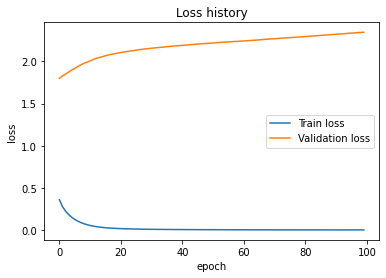

In [ ]:
# Loss history를 그린다
plt.plot(hist.history['loss'], label='Train loss')
plt.plot(hist.history['val_loss'], label='Validation loss')
plt.legend()
plt.title("Loss history")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

In [ ]:
with open('/content/drive/MyDrive/머신러닝/기계번역chatbot/translate_train_test.pkl', 'wb') as f:
    pickle.dump([trainXE, trainXD, trainYD, testXE, testXD, testYD], f, pickle.HIGHEST_PROTOCOL) 

In [ ]:
# STEP3
!!pip install sentencepiece

['Requirement already satisfied: sentencepiece in /usr/local/lib/python3.7/dist-packages (0.1.96)']

In [ ]:
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.layers import Embedding, TimeDistributed
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
import sentencepiece as spm
import numpy as np
import pickle
from nltk.translate.bleu_score import sentence_bleu

In [ ]:
with open('/content/drive/MyDrive/머신러닝/기계번역chatbot/enc_voc.pkl', 'rb') as f:
  enc_word2idx, enc_idx2word = pickle.load(f)

with open('/content/drive/MyDrive/머신러닝/기계번역chatbot/dec_voc.pkl', 'rb') as f:
  dec_word2idx, dec_idx2word = pickle.load(f)

with open('/content/drive/MyDrive/머신러닝/기계번역chatbot/translate_train_test.pkl', 'rb') as f:
  trainXE, trainXD, trainYD, testXE, testXD, testYD = pickle.load(f)

In [ ]:
ENC_MAX_LEN = 15
DEC_MAX_LEN = 15
ENC_VOCAB_SIZE = len(enc_idx2word)
DEC_VOCAB_SIZE = len(dec_idx2word)
EMB_SIZE = 128
LSTM_HIDDEN = 128
MODEL_PATH = '/content/drive/MyDrive/머신러닝/기계번역chatbot/translate_trained.h5'

# 데이터 전처리 과정에서 생성한 SentencePiece model을 불러온다.
SPM_ENC_MODEL = "/content/drive/MyDrive/머신러닝/기계번역chatbot/machine_trans_enc_model.model"
enc_sp = spm.SentencePieceProcessor()
enc_sp.Load(SPM_ENC_MODEL)

SPM_DEC_MODEL = "/content/drive/MyDrive/머신러닝/기계번역chatbot/machine_trans_dec_model.model"
dec_sp = spm.SentencePieceProcessor()
dec_sp.Load(SPM_DEC_MODEL)

True

In [ ]:
# Encoder 출력과 decoder 출력으로 attention value를 생성하고,
# decoder 출력 + attention value (concatenate)를 리턴한다.
# x : encoder 출력, y : decoder 출력
# LSTM time step = 4, SMB_SIZE = 3 이라면 각 텐서의 dimension은
# 아래 주석과 같다.
def Attention(x, y):
    # step-1:
    # decoder의 매 시점마다 encoder의 전체 시점과 dot-product을 수행한다.
    score = Dot(axes=(2, 2))([y, x])                   # (1, 4, 4)
    
    # step-2:
    # dot-product 결과를 확률분포로 만든다 (softmax)
    # 이것이 attention score이다.
    dist = Activation('softmax')(score)                # (1, 4, 4)

    # step-3:
    # Attention value를 계산한다.
    attention = Dot(axes=(2, 1))([dist, x])

    # step-4:
    # decoder 출력과 attention을 concatenate 한다.
    return Concatenate()([y, attention])    # (1, 4, 6)

In [ ]:
# 워드 임베딩 레이어. Encoder와 decoder에서 공동으로 사용한다.
K.clear_session()
wordEmbedding = Embedding(input_dim=ENC_VOCAB_SIZE, output_dim=EMB_SIZE)
wordEmbedding1 = Embedding(input_dim=DEC_VOCAB_SIZE, output_dim=EMB_SIZE)

# Encoder
# -------
encoderX = Input(batch_shape=(None, MAX_LEN))
encEMB = wordEmbedding(encoderX)
encLSTM1 = LSTM(LSTM_HIDDEN, return_sequences=True, return_state = True)
encLSTM2 = LSTM(LSTM_HIDDEN, return_sequences=True, return_state = True)
ey1, eh1, ec1 = encLSTM1(encEMB)      # LSTM 1층 
ey2, eh2, ec2 = encLSTM2(ey1)         # LSTM 2층

# Decoder
# -------
# Decoder는 1개 단어씩을 입력으로 받는다. 학습 때와 달리 문장 전체를 받아
# recurrent하는 것이 아니라, 단어 1개씩 입력 받아서 다음 예상 단어를 확인한다.
# chatting()에서 for 문으로 단어 별로 recurrent 시킨다.
# 따라서 batch_shape = (None, 1)이다. 즉, time_step = 1이다. 그래도 네트워크
# 파라메터는 동일하다.
decoderX = Input(batch_shape=(None, 1))
decEMB = wordEmbedding1(decoderX)
decLSTM1 = LSTM(LSTM_HIDDEN, return_sequences=True, return_state=True)
decLSTM2 = LSTM(LSTM_HIDDEN, return_sequences=True, return_state=True)
dy1, _, _ = decLSTM1(decEMB, initial_state = [eh1, ec1])
dy2, _, _ = decLSTM2(dy1, initial_state = [eh2, ec2])
att_dy2 = Attention(ey2, dy2)
decOutput = TimeDistributed(Dense(VOCAB_SIZE, activation='softmax'))
outputY = decOutput(att_dy2)

# Model
# -----
model = Model([encoderX, decoderX], outputY)
model.load_weights(MODEL_PATH)

In [ ]:
# Chatting용 model
model_enc = Model(encoderX, [eh1, ec1, eh2, ec2, ey2])

ih1 = Input(batch_shape = (None, LSTM_HIDDEN))
ic1 = Input(batch_shape = (None, LSTM_HIDDEN))
ih2 = Input(batch_shape = (None, LSTM_HIDDEN))
ic2 = Input(batch_shape = (None, LSTM_HIDDEN))
ey = Input(batch_shape = (None, MAX_LEN, LSTM_HIDDEN))

dec_output1, dh1, dc1 = decLSTM1(decEMB, initial_state = [ih1, ic1])
dec_output2, dh2, dc2 = decLSTM2(dec_output1, initial_state = [ih2, ic2])
dec_attention = Attention(ey, dec_output2)
dec_output = decOutput(dec_attention)
model_dec = Model([decoderX, ih1, ic1, ih2, ic2, ey], 
                  [dec_output, dh1, dc1, dh2, dc2])

In [ ]:
# Question을 입력받아 Answer를 생성한다.
def genAnswer(question):
    question = question[np.newaxis, :]
    init_h1, init_c1, init_h2, init_c2, enc_y = model_enc.predict(question)

    # 시작 단어는 <BOS>로 한다.
    word = np.array(sp.bos_id()).reshape(1, 1)

    answer = []
    for i in range(MAX_LEN):
        dY, next_h1, next_c1, next_h2, next_c2 = \
            model_dec.predict([word, init_h1, init_c1, init_h2, init_c2, enc_y])
        
        # 디코더의 출력은 vocabulary에 대응되는 one-hot이다.
        # argmax로 해당 단어를 채택한다.
        nextWord = np.argmax(dY[0, 0])

        # 예상 단어가 <EOS>이거나 <PAD>이면 더 이상 예상할 게 없다.
        if nextWord == sp.eos_id() or nextWord == sp.pad_id():
            break
        
        # 다음 예상 단어인 디코더의 출력을 answer에 추가한다.
        answer.append(idx2word[nextWord])
        
        # 디코더의 다음 recurrent를 위해 입력 데이터와 hidden 값을
        # 준비한다. 입력은 word이고, hidden은 h와 c이다.
        word = np.array(nextWord).reshape(1,1)
    
        init_h1 = next_h1
        init_c1 = next_c1
        init_h2 = next_h2
        init_c2 = next_c2
        
    return sp.decode_pieces(answer)

In [ ]:
def make_question(que_string):
    q_idx = []
    for x in sp.encode_as_pieces(que_string):
        if x in word2idx:
            q_idx.append(word2idx[x])
        else:
            q_idx.append(sp.unk_id())   # out-of-vocabulary (OOV)
    
    # <PAD>를 삽입한다.
    if len(q_idx) < MAX_LEN:
        q_idx.extend([sp.pad_id()] * (MAX_LEN - len(q_idx)))
    else:
        q_idx = q_idx[0:MAX_LEN]
    return q_idx

In [ ]:
# BLEU 평가를 위해 시험 데이터를 읽어온다.
with open('/content/drive/MyDrive/머신러닝/기계번역chatbot/chatbot_train.pkl', 'rb') as f:
    _, _, _, que_test, ans_test = pickle.load(f)

In [ ]:
# BLEU 평가
bleu_list = []
for que_str, reference in zip(que_test[:20], ans_test[:20]):
    q_idx = make_question(que_str)
    candidate = genAnswer(np.array(q_idx))

    # BLEU를 측정한다.
    # 기계번역의 reference는 어느정도 객관성이 있지만, 일상 대화용 챗봇의 reference는 매우 주관적이기 때문에,
    # test data로 측정한 챗봇의 BLEU는 매우 낮을 수밖에 없다. 특정 업무를 위한 챗봇의 reference는 어느정도
    # 객관성이 있을 수 있다.
    #
    # 1. 짧은 문장이 많기 때문에 단어가 아닌 subword 단위로 BLEU를 측정한다.
    # 2. (Papineni et al. 2002)은 micro-average를 사용했지만, 여기서는 단순 평균인 macro-average를 사용한다.
    reference = sp.encode_as_pieces(reference)
    candidate = sp.encode_as_pieces(candidate)

    bleu = sentence_bleu([reference], candidate, weights=[1/2., 1/2.])
    bleu_list.append(bleu)
    print(que_str, '-->', sp.decode_pieces(candidate), ':', np.round(bleu, 4))
print('Average BLEU score =', np.round(np.mean(bleu_list), 4))

좋아하는 애랑 영화 볼건데 액션은 좀 그렇겠지 --> I like the movie I like to see the movie. : 0


/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


썸을 오래 탔는데 사귀어도 되는 거야 --> I have a long step, but I can dating. : 0.2887
너무 힘들다 지쳤어 --> It's tired too hard. : 0
에궁 --> Ealycher : 0
중국으로 진출해볼까 --> I'll go to China too : 0
사귀고 나서 트레이닝복만 입어 --> After dating, : 0
혹시 그런 날 없나 --> I can not do that. : 0
오늘 헤어졌어여 --> I broke up today. : 0
너무나도 힘들어 --> It's so hard. : 0
야경 보러 가고 싶다 --> I want to go to night view : 0
어떻게 맘정리를할까 --> How do I organize my heart? : 0
이 멍충아 --> This : 0
택배 왜 안오지 --> Why not I have a courier : 0.378
남사친이 많은 썸녀 --> A lot of boyfriend : 0
꽃게탕 진짜 밥도둑 --> Flower Baskang Real Bob Thief : 0
죽을만큼 보고싶다 --> I want to die : 0
유부남 좋아하면 안되겠지 --> You can not do it. : 0
2년째 좋아하는 사람이 있어 --> I have someone who likes 2 years. : 0
비정규직이라 차별받아 --> Non-regular workers : 0
여자가 남자한테 잘해주면 질려 --> If a woman is good for a man, : 0
Average BLEU score = 0.0333


In [ ]:
# Chatting
# dummy : 최초 1회는 모델을 로드하는데 약간의 시간이 걸리므로 이것을 가리기 위함.
def chatting(n=100):
    for i in range(n):
        question = input('Q : ')
        
        if  question == 'quit':
            break
        
        q_idx = make_question(question)
        answer = genAnswer(np.array(q_idx))
        print('A :', answer)

In [ ]:
####### Chatting 시작 #######
print("\nSeq2Seq ChatBot (ver. 1.0)")
print("Chatting 모듈을 로드하고 있습니다 ...")

# 처음 1회는 시간이 걸리기 때문에 dummy question을 입력한다.
answer = genAnswer(np.zeros(MAX_LEN))
print("ChatBot이 준비 됐습니다.")

# 채팅을 시작한다.
chatting(100)


Seq2Seq ChatBot (ver. 1.0)
Chatting 모듈을 로드하고 있습니다 ...
ChatBot이 준비 됐습니다.
Q : 12시 땡
A : 12 o'clock
Q : 가스비 너무 많이 나왔다	
A : Gasby has been too much.
Q : quit
